# Predicting fraudulent credit card transactions

Adrián P. Bustamante, Ph.D.\
email: adrianpebus@gmail.com

## 1. Objective <a class="anchor" id="objective"></a>

We study a dataset containing transactions made by credit cards that occurred during two days in 2013. The dataset is highly unbalanced, we have 492 frauds out of  284 807 transactions, roughly the 0.172% of all transactions. 

The objective of this study is to train different classification models to predict whether a transaction is fraudulent or not. We want to find a model that performs well on precision, recall, and fscore.

Our focus is on predictability but we also include a couple of results on interpretability. To measure the performance of the models considered we will be focusing on precision, recall and f1score.

## 2. About the data <a class="anchor" id="data"></a>

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset present transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML.

The dataset used for this project can be found at https://www.kaggle.com/datasets/qnqfbqfqo/credit-card-fraud-detection-date-25th-of-june-2015

In [65]:
import kagglehub
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay, roc_auc_score
from sklearn.inspection import permutation_importance


# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier

In [32]:
# Download and load the dataset
path = kagglehub.dataset_download("qnqfbqfqo/credit-card-fraud-detection-date-25th-of-june-2015")
data = pd.read_csv(f"{path}/creditcard_csv.csv")
df = data.copy()

print("Initial shape:", df.shape)
#print(path)
df.head()

Initial shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


## 3. EDA and Feature Engineering <a class="anchor" id="eda"></a>

##### Feature Enginering

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [34]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


In [35]:
## we drop the feature time, because it only marks the time passed since the first transaction in the dataset.

# Drop 'Time' column as it is not a predictive feature.
df.drop('Time', axis=1, inplace=True)

# Convert the 'Class' column to a numerical integer (0 for legitimate, 1 for fraudulent).
print(df['Class'].value_counts())
df['Class'] = df['Class'].apply(lambda x: int(x[1]))
df['Class'].value_counts()

Class
'0'    284315
'1'       492
Name: count, dtype: int64


Class
0    284315
1       492
Name: count, dtype: int64

In [36]:
# Remove duplicate rows to ensure the integrity of our dataset and avoid training on redundant data.
print(f"Number of rows before dropping duplicates: {df.shape[0]}")
df.drop_duplicates(keep='first', inplace=True)
print(f"Number of rows after dropping duplicates: {df.shape[0]}")

Number of rows before dropping duplicates: 284807
Number of rows after dropping duplicates: 275663


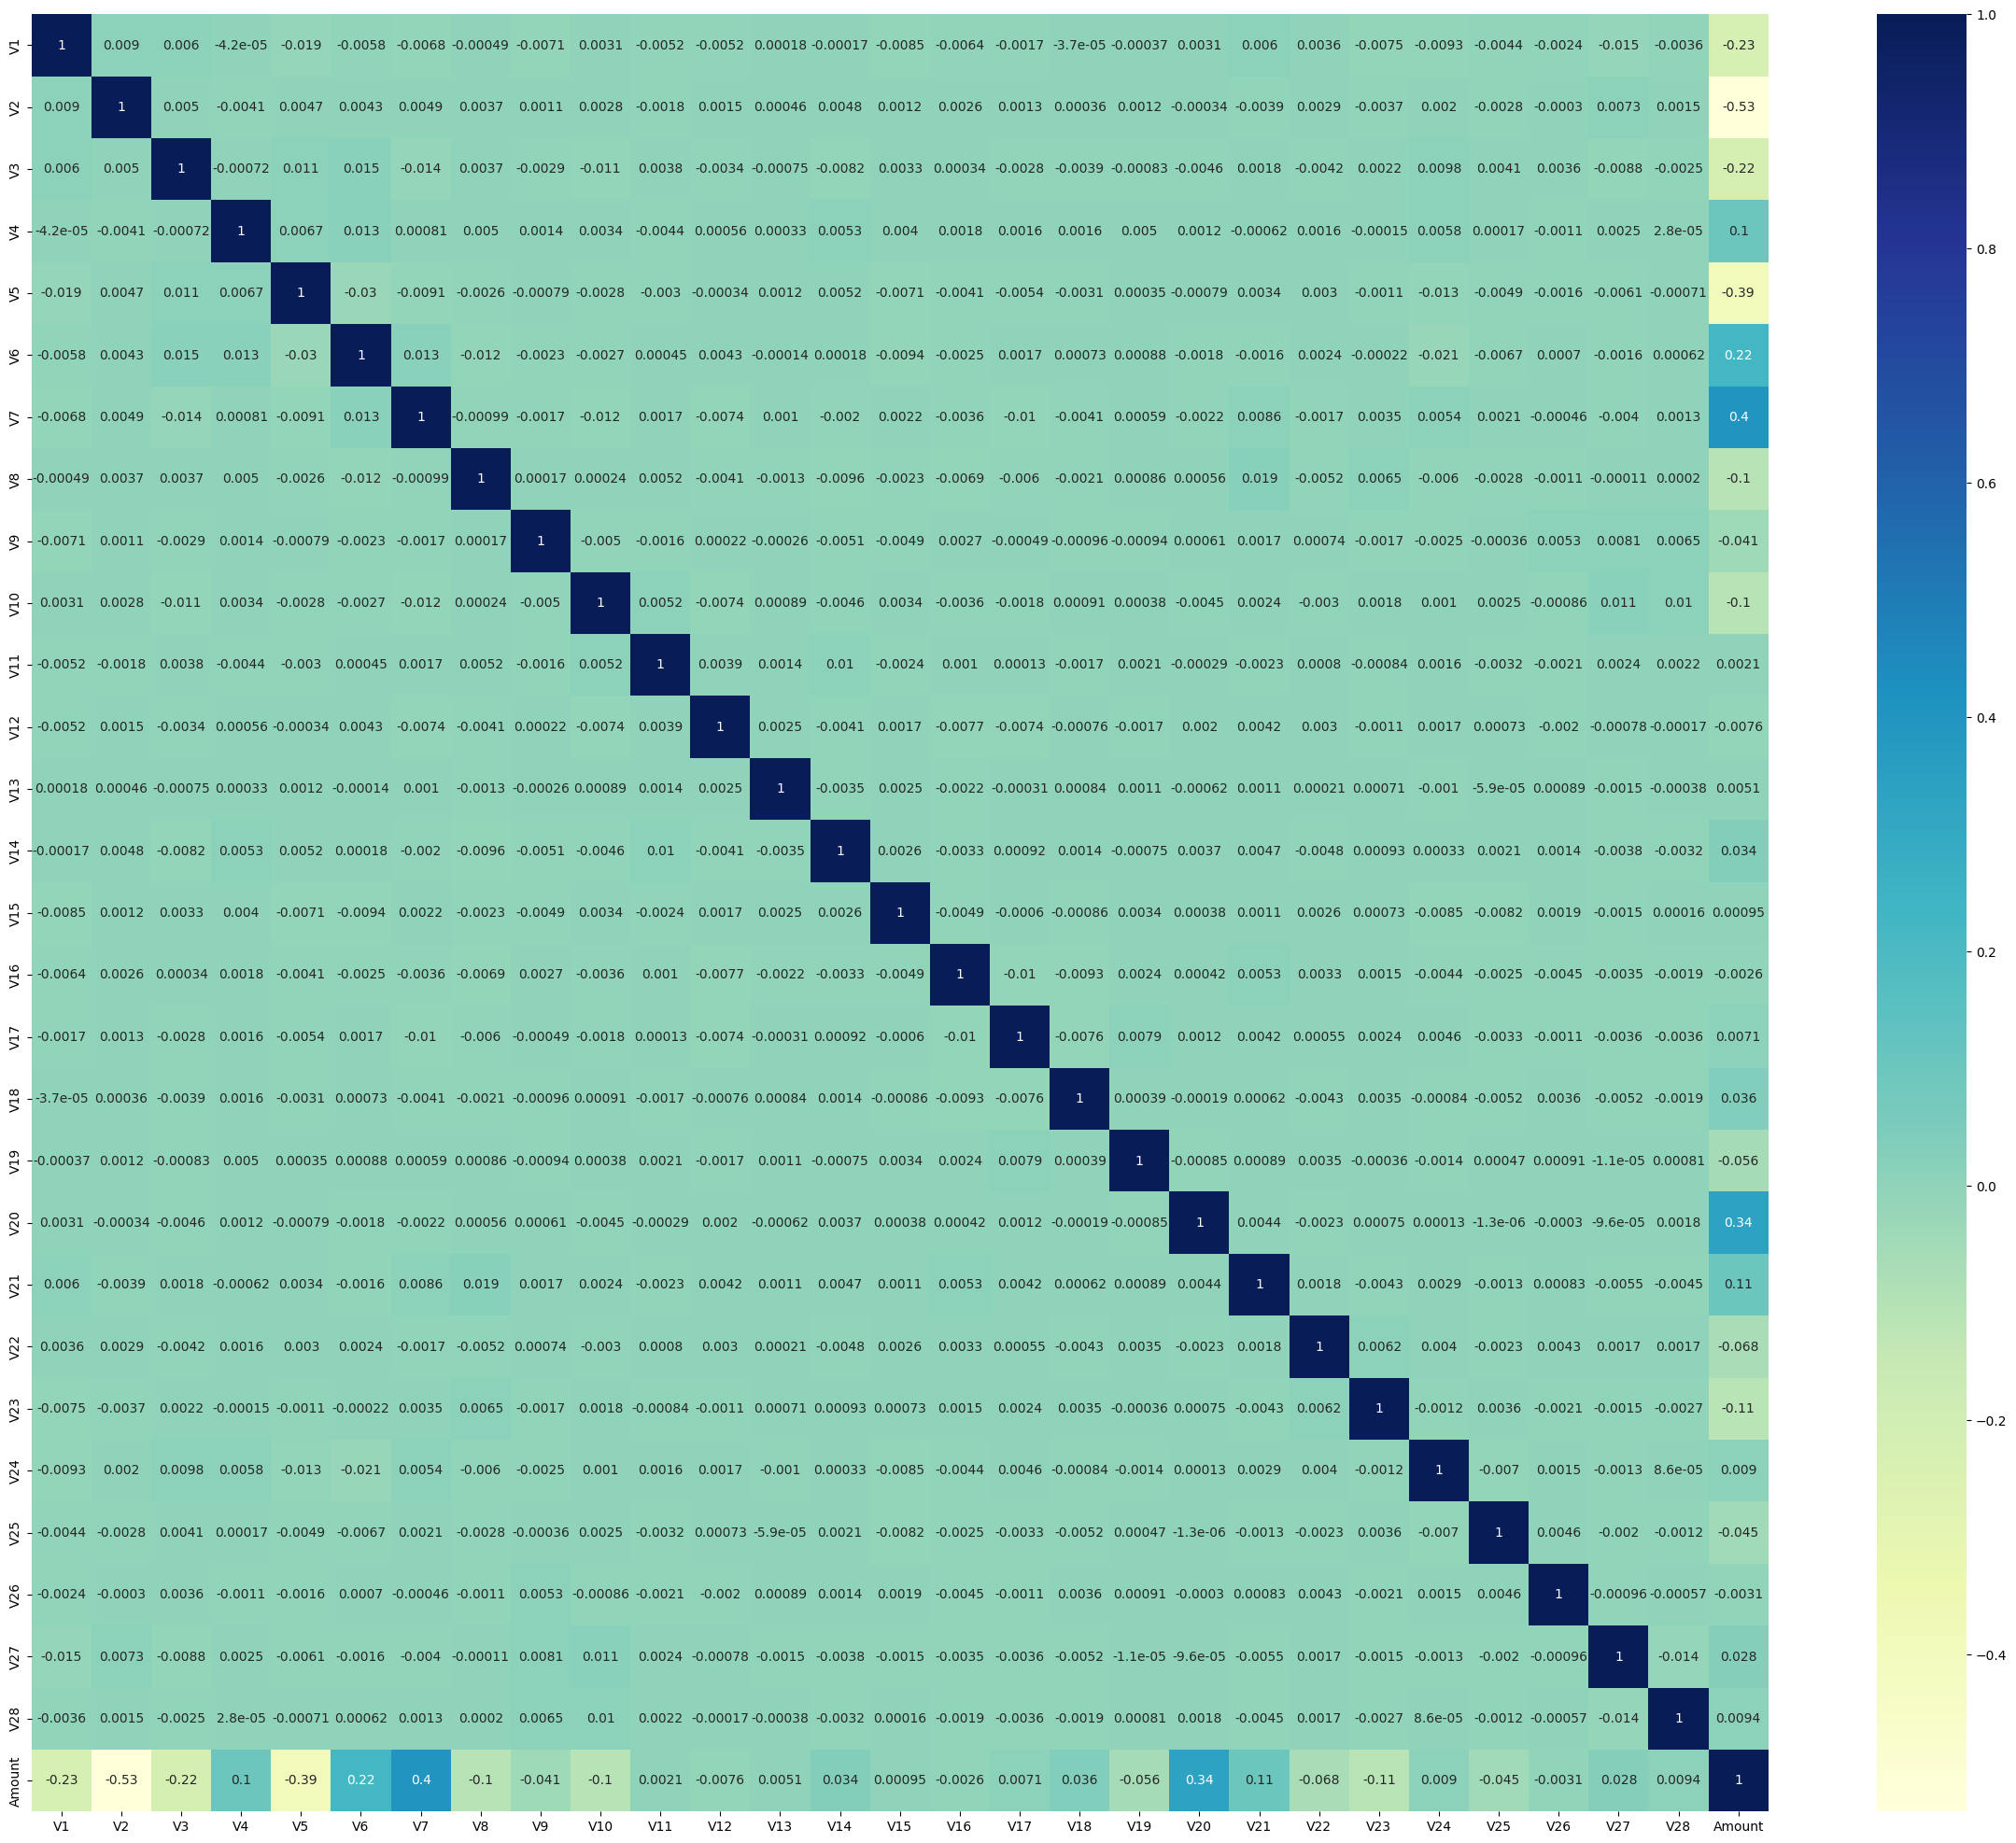

In [37]:
df['Class'].value_counts()

plt.figure(figsize=(30,25))
sns.heatmap(df.iloc[:, :-1].corr(), annot=True, cmap = 'YlGnBu')
plt.show()


Class distribution:
Class
0    0.998284
1    0.001716
Name: proportion, dtype: float64


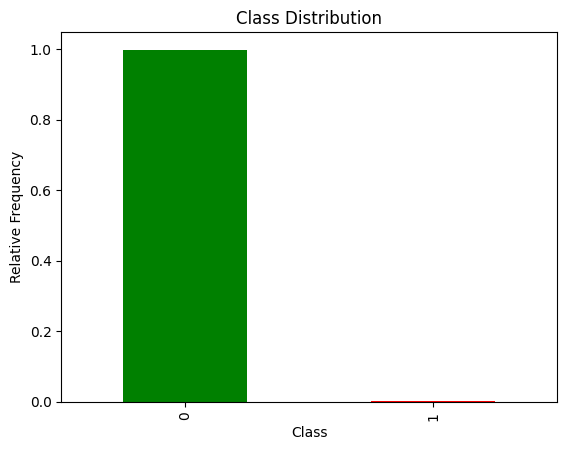

In [38]:
##### Imbalanced classes

# Visualize the highly imbalanced nature of the dataset.
print("\nClass distribution:")
print(df['Class'].value_counts(normalize=True))
df['Class'].value_counts(normalize=True).plot.bar(color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Relative Frequency')
plt.show()

## 4. Classification Models <a class="anchor" id="models"></a>

In [39]:
# Scaling and resampling will be applied only to the training data.
# We use a 50% test size for faster prototyping on limited computational resources.

X = df.drop('Class', axis=1).copy()
y = df['Class'].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=666)

print(f"Original Training set shape: {X_train.shape}")
print(f"Original Test set shape: {X_test.shape}")

Original Training set shape: (137831, 29)
Original Test set shape: (137832, 29)


In [40]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
##### Utility methods

results_final = []

def eval_metrics(ytrue, ypred, model_name='model'):
    precision, recall, fscore, _ = precision_recall_fscore_support(ytrue, ypred, pos_label=1, average='binary')
    return {
        'model': model_name,
        'accuracy': accuracy_score(ytrue, ypred),
        'precision': precision,
        'recall': recall,
        'fscore': fscore,
        'auc': roc_auc_score(ytrue, ypred)
    }

def plot_confusion_matrix(ytrue, ypred, model, title):
    disp = ConfusionMatrixDisplay.from_predictions(ytrue, ypred, display_labels=model.classes_)
    disp.ax_.set_title(title)
    plt.show()

### Logistic Regression

Best Logistic Regression Parameters: {'class_weight': {0: 0.025, 1: 0.975}}


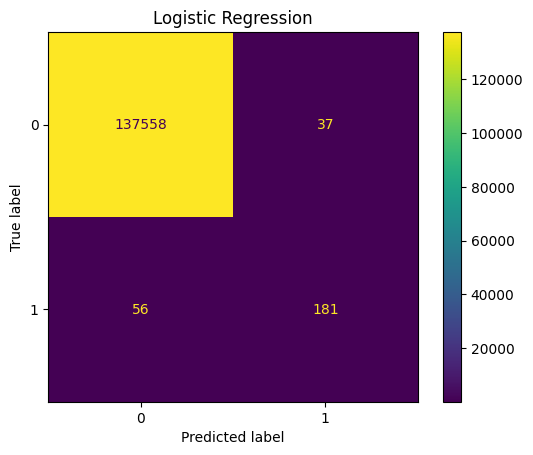

In [43]:
logreg = LogisticRegression(penalty='l2', solver='sag', random_state=666, max_iter=1000)
params_grid = {'class_weight': [{0: 0.05, 1: 0.95}, {0: 0.025, 1: 0.975}]} #class_weight : dict or 'balanced', default=None 
#Weights associated with classes in the form ``{class_label: weight}``.
  #  If not given, all classes are supposed to have weight one.
search = GridSearchCV(estimator=logreg, param_grid=params_grid, scoring='f1', cv=3, n_jobs=7)
search.fit(X_train_scaled, y_train)
best_logreg = search.best_estimator_
y_pred_best_logreg = best_logreg.predict(X_test_scaled)
results_final.append(eval_metrics(y_test, y_pred_best_logreg, model_name='log_reg_final'))
print("Best Logistic Regression Parameters:", search.best_params_)
plot_confusion_matrix(y_test, y_pred_best_logreg, best_logreg, 'Logistic Regression')

### K-Nearest Neighbors

Best KNN Parameters: {'n_neighbors': 3}


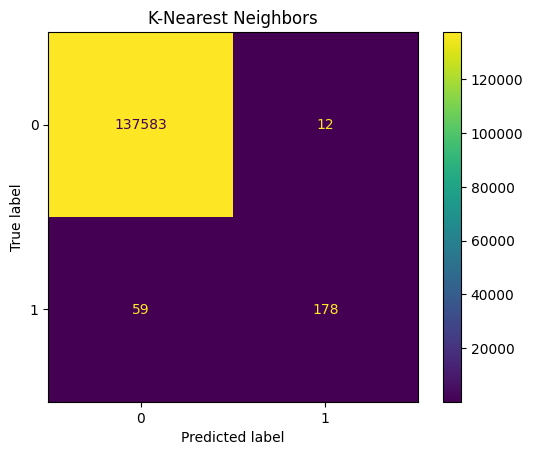

In [45]:
# A non-linear model sensitive to feature scaling and distance.
knn = KNeighborsClassifier()
params_grid_knn = {'n_neighbors': [3, 5, 7]}
search_knn = GridSearchCV(estimator=knn, param_grid=params_grid_knn, scoring='f1', cv=3, n_jobs=7)
search_knn.fit(X_train_scaled, y_train)
best_knn = search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
results_final.append(eval_metrics(y_test, y_pred_knn, model_name='knn_final'))
print("Best KNN Parameters:", search_knn.best_params_)
plot_confusion_matrix(y_test, y_pred_knn, best_knn, 'K-Nearest Neighbors')

### Support Vector Classifier

Best SVC Parameters: {'C': 1, 'kernel': 'rbf'}


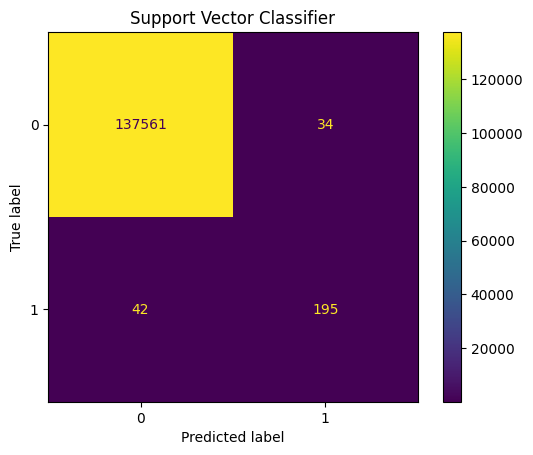

In [46]:
#  non-linear model, also requiring scaling.
svc = SVC(random_state=666)
params_grid_svc = {'C': [1, 10], 'kernel': ['rbf']} # Reduced for notebook speed, C is the regularization parameter
search_svc = GridSearchCV(estimator=svc, param_grid=params_grid_svc, scoring='f1', cv=3, n_jobs=7)
search_svc.fit(X_train_scaled, y_train)
best_svc = search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test_scaled)
results_final.append(eval_metrics(y_test, y_pred_svc, model_name='svc_final'))
print("Best SVC Parameters:", search_svc.best_params_)
plot_confusion_matrix(y_test, y_pred_svc, best_svc, 'Support Vector Classifier')

### Bagging Trees

Best Bagging Parameters: {'n_estimators': 40}


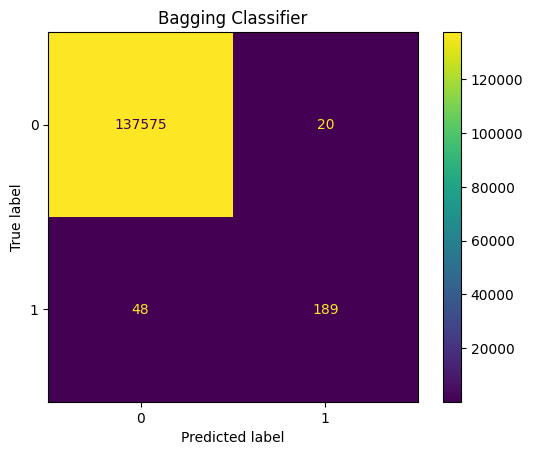

In [48]:
# Bagging tress 
# This model do not require scaling and are robust to feature distributions
bag = BaggingClassifier(estimator=DecisionTreeClassifier(criterion='gini', random_state=666), 
                        bootstrap=True, warm_start=True, random_state=666)
params_grid_bag = {'n_estimators': [20,30, 40, 50]}
search_bag = GridSearchCV(estimator=bag, param_grid=params_grid_bag, scoring='f1', cv=3, n_jobs=7)
search_bag.fit(X_train, y_train) # Training on raw, unscaled data
best_bag = search_bag.best_estimator_
y_pred_bag = best_bag.predict(X_test)
results_final.append(eval_metrics(y_test, y_pred_bag, model_name='bagging_final'))
print("Best Bagging Parameters:", search_bag.best_params_)
plot_confusion_matrix(y_test, y_pred_bag, best_bag, 'Bagging Classifier')

### Random Forests

Best Random Forest Parameters: {'max_depth': 10, 'n_estimators': 50}


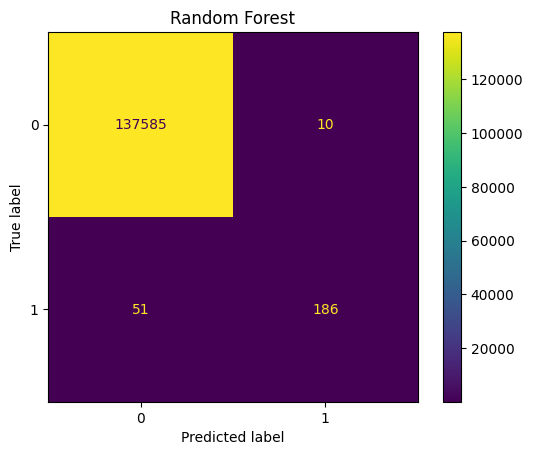

In [49]:
# Random Forest
# This model do not require scaling and are robust to feature distributions
rf = RandomForestClassifier(random_state=666, warm_start=True)
params_grid_rf = {'n_estimators': [20,30,40,50], 'max_depth': [10, 20, 30]}
search_rf = GridSearchCV(estimator=rf, param_grid=params_grid_rf, scoring='f1', cv=3, n_jobs=7)
search_rf.fit(X_train, y_train) # Training on raw, unscaled data
best_rf = search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
results_final.append(eval_metrics(y_test, y_pred_rf, model_name='rforest_final'))
print("Best Random Forest Parameters:", search_rf.best_params_)
plot_confusion_matrix(y_test, y_pred_rf, best_rf, 'Random Forest')

In [50]:
### Gradient Boosting

Best XGBoost Parameters: {'learning_rate': 0.1, 'n_estimators': 50}


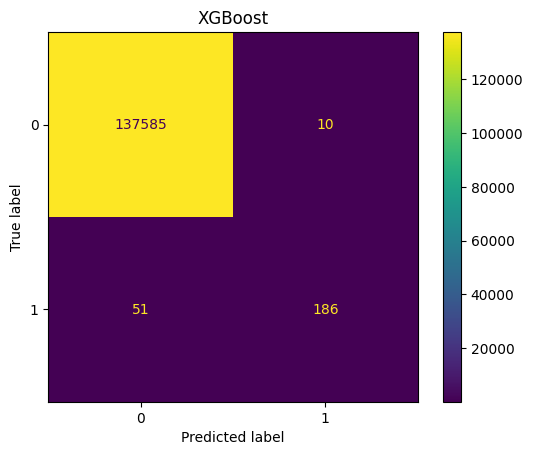

In [51]:
# A high-performance boosting algorithm.
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=666)
params_grid_xgb = {'learning_rate': [0.1, 0.2, 0.3, 0.4], 'n_estimators': [10, 20, 30, 40, 50]}
search_xgb = GridSearchCV(estimator=xgb, param_grid=params_grid_xgb, scoring='f1', cv=3, n_jobs=7)
search_xgb.fit(X_train, y_train) # Training on raw, unscaled data
best_xgb = search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
results_final.append(eval_metrics(y_test, y_pred_xgb, model_name='xgboost_final'))
print("Best XGBoost Parameters:", search_xgb.best_params_)
plot_confusion_matrix(y_test, y_pred_xgb, best_xgb, 'XGBoost')

## 5. Summary of results and interpretability <a class="anchor" id="summary"></a>

               accuracy  precision    recall    fscore       auc
model                                                           
log_reg_final  0.999325   0.830275  0.763713  0.795604  0.881722
log_reg_final  0.999325   0.830275  0.763713  0.795604  0.881722
knn_final      0.999485   0.936842  0.751055  0.833724  0.875484
svc_final      0.999449   0.851528  0.822785  0.836910  0.911269
bagging_final  0.999507   0.904306  0.797468  0.847534  0.898662
rforest_final  0.999557   0.948980  0.784810  0.859122  0.892369
xgboost_final  0.999557   0.948980  0.784810  0.859122  0.892369


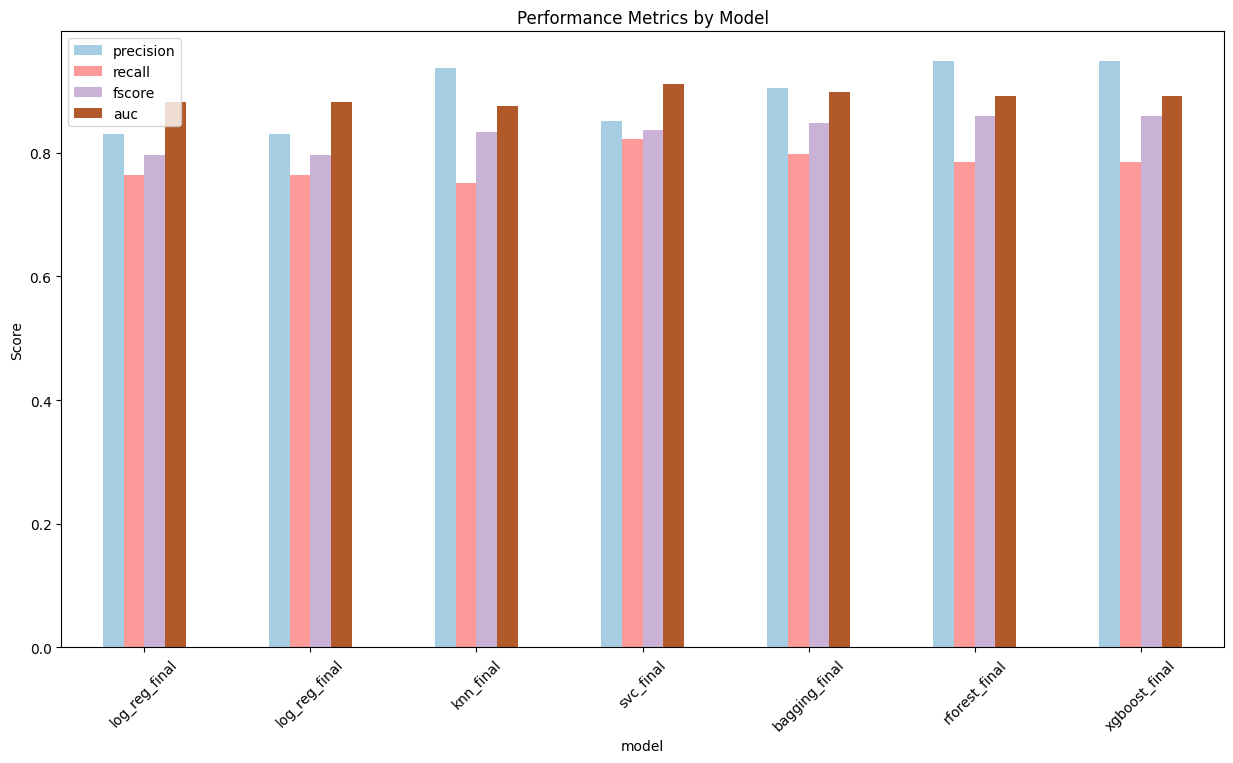

In [52]:
##### Summary

pd.DataFrame(data=results_final)

# A visual comparison of all trained models shows the effectiveness of different approaches.
df_results = pd.DataFrame(data=results_final)
df_results.set_index('model', inplace=True)
print(df_results)
df_results[['precision', 'recall', 'fscore', 'auc']].plot(
    kind='bar', figsize=(15, 8), rot=45, colormap='Paired'
)
plt.title('Performance Metrics by Model')
plt.ylabel('Score')
plt.show()

 Best model: XGboost presents the largest f1-score

### Permutation feature importance


Analyzing feature importance for the best model: XGB


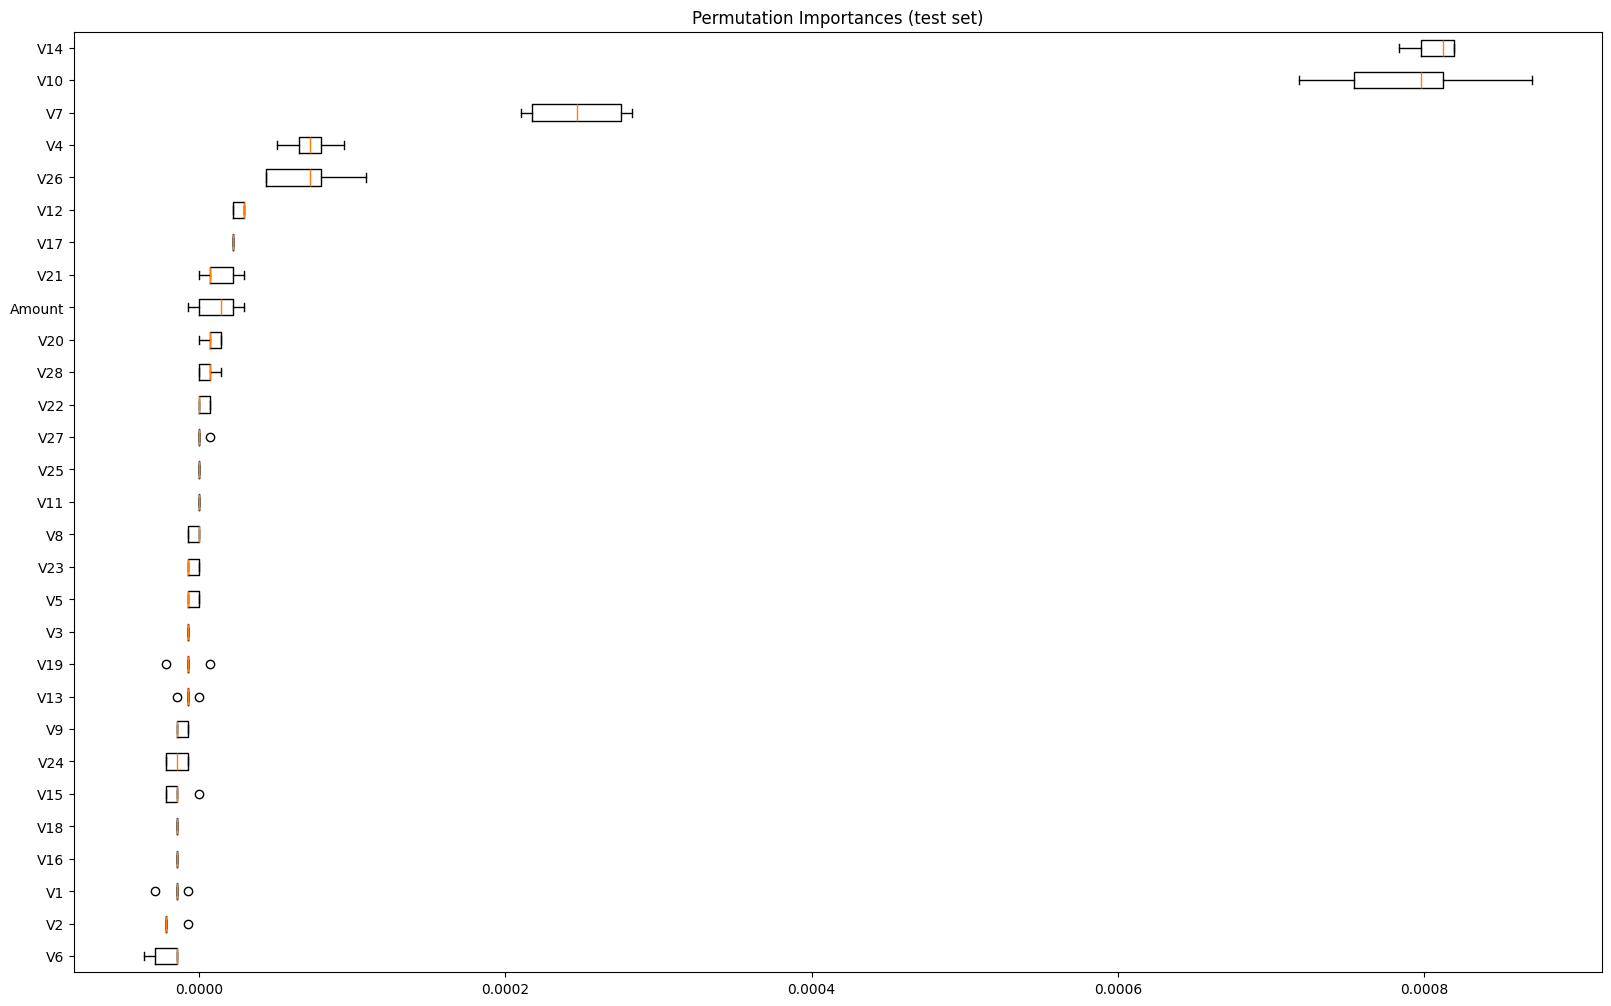

In [57]:
# Permutation Feature Importance for the best model.
print("\nAnalyzing feature importance for the best model: XGB")

feature_importances = permutation_importance(estimator=best_xgb, X = X_test, y = y_test, n_repeats=5,
                                random_state=123, n_jobs=-1)
sorted_idx = feature_importances.importances_mean.argsort()
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(10)
fig.tight_layout()
ax.boxplot(feature_importances.importances[sorted_idx].T[:10],
               vert=False, tick_labels=df.drop('Class', axis=1).columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.show()

## 6. Conclusion and next steps <a class="anchor" id="conclusion"></a>

Our objective for this project was to develop a robust classification model to identify fraudulent credit card transactions, with a primary focus on maximizing Precision, Recall, and F1-score. Given the highly imbalanced nature of the dataset, these metrics were prioritized over traditional accuracy.

Among the models evaluated—including Logistic Regression, K-Nearest Neighbors, Support Vector Classifier, Random Forest, and XGBoost—the XGBoost Classifier emerged as the best-performing model. It achieved a F1-score of approximately 0.86, with a Precision of around 0.95 and a Recall of 0.78. The high precision is particularly valuable in a fraud detection context, as it indicates a low rate of false alarms, which is crucial for minimizing the workload of human review teams.


To further improve the model, future work could include:

    More Exhaustive Hyperparameter Tuning: A more extensive grid search or the use of automated machine learning (AutoML) tools could be applied to fine-tune the hyperparameters of the ensemble models, potentially allowing them to capture more nuanced patterns.

    Alternative Resampling Techniques: Experimenting with more advanced resampling methods or anomaly detection algorithms could provide a more balanced training signal and potentially boost the performance of the ensemble.

    Cost-Sensitive Learning: Given the high cost of a missed fraud detection (a false negative), exploring cost-sensitive learning frameworks that directly penalize misclassifications of the positive class could lead to a more effective model from a business perspective.

In [54]:
X_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
111813,0.996331,-0.308708,1.312186,1.833856,-0.975436,0.396794,-0.540867,0.300969,1.350923,-0.407110,...,-0.210312,-0.384770,-0.742331,0.107058,0.373897,0.342540,-0.529864,0.080586,0.035537,41.50
48761,-2.942248,-2.957802,-0.460539,1.100759,-2.662918,2.320202,3.955415,-0.446563,-2.008210,0.062004,...,-0.513236,-0.330803,0.326168,2.279299,-0.322243,0.309647,-0.124813,0.687298,-0.247168,1025.00
80270,-0.388250,1.039200,1.258596,0.019209,0.181841,-0.537154,0.582521,0.097939,-0.314384,-0.536712,...,0.044792,-0.242878,-0.619973,0.017982,0.008081,-0.252426,0.103474,0.258968,0.093753,0.99
255386,1.583058,-2.224145,-1.470876,-2.448540,-1.220677,-0.676241,-0.244315,-0.325626,1.426636,-0.772257,...,0.124018,-0.562585,-1.521935,0.058279,-0.815253,-0.355695,-1.237618,0.042466,0.021580,338.79
111439,-3.597137,1.283455,0.341048,0.238386,-1.323467,-0.012776,-1.224243,1.767659,0.030097,-0.715955,...,-0.255403,-0.105297,-0.140332,-0.149613,-0.355786,0.580358,0.420536,0.043924,-0.409902,11.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150666,-10.850282,6.727466,-16.760583,8.425832,-10.252697,-4.192171,-14.077086,7.168288,-3.683242,-15.239962,...,-0.646818,2.541637,0.135535,-1.023967,0.406265,0.106593,-0.026232,-1.464630,-0.411682,78.00
194419,2.222575,-0.927717,-2.779995,-1.948703,1.990571,3.128615,-0.858929,0.698846,-0.632931,0.813884,...,0.007462,0.019409,-0.001718,0.238992,0.711492,0.027769,-0.257353,-0.019245,-0.071159,4.13
85590,-0.213679,0.409990,0.061892,-1.163371,-0.291369,-0.068158,0.103698,0.409548,1.201471,-1.580549,...,-0.033725,0.029465,0.234693,-0.199965,-0.980239,0.239695,-0.522914,-0.007295,-0.031169,50.00
43395,-1.005258,1.126327,0.695304,-1.560085,0.111260,-0.441303,0.367341,0.444087,-0.502268,-0.651572,...,-0.045657,0.006667,-0.113444,-0.154020,-0.445243,-0.177140,0.785882,-0.006822,0.090993,7.99


In [56]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 137832 entries, 111813 to 161593
Series name: Class
Non-Null Count   Dtype
--------------   -----
137832 non-null  int64
dtypes: int64(1)
memory usage: 2.1 MB


In [59]:
def plot_feature_importance(model, X_test, y_test, feature_names):
    """Creates a box plot of permutation feature importance on the test set."""
    print("Analyzing feature importance for the best model...")
    feature_importances = permutation_importance(
        estimator=model, X=X_test, y=y_test, n_repeats=5,
        random_state=123, n_jobs=-1
    )
    sorted_idx = feature_importances.importances_mean.argsort()
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(10)
    fig.tight_layout()
    ax.boxplot(feature_importances.importances[sorted_idx].T[:10],
               vert=False, tick_labels=feature_names[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    plt.show()

def preprocess_data(df: pd.DataFrame):
    """Performs data cleaning and feature engineering."""
    df.drop('Time', axis=1, inplace=True)
    df['Class'] = df['Class'].apply(lambda x: int(x[1]))
    df.drop_duplicates(keep='first', inplace=True)
    return df


Analyzing feature importance for the best model...


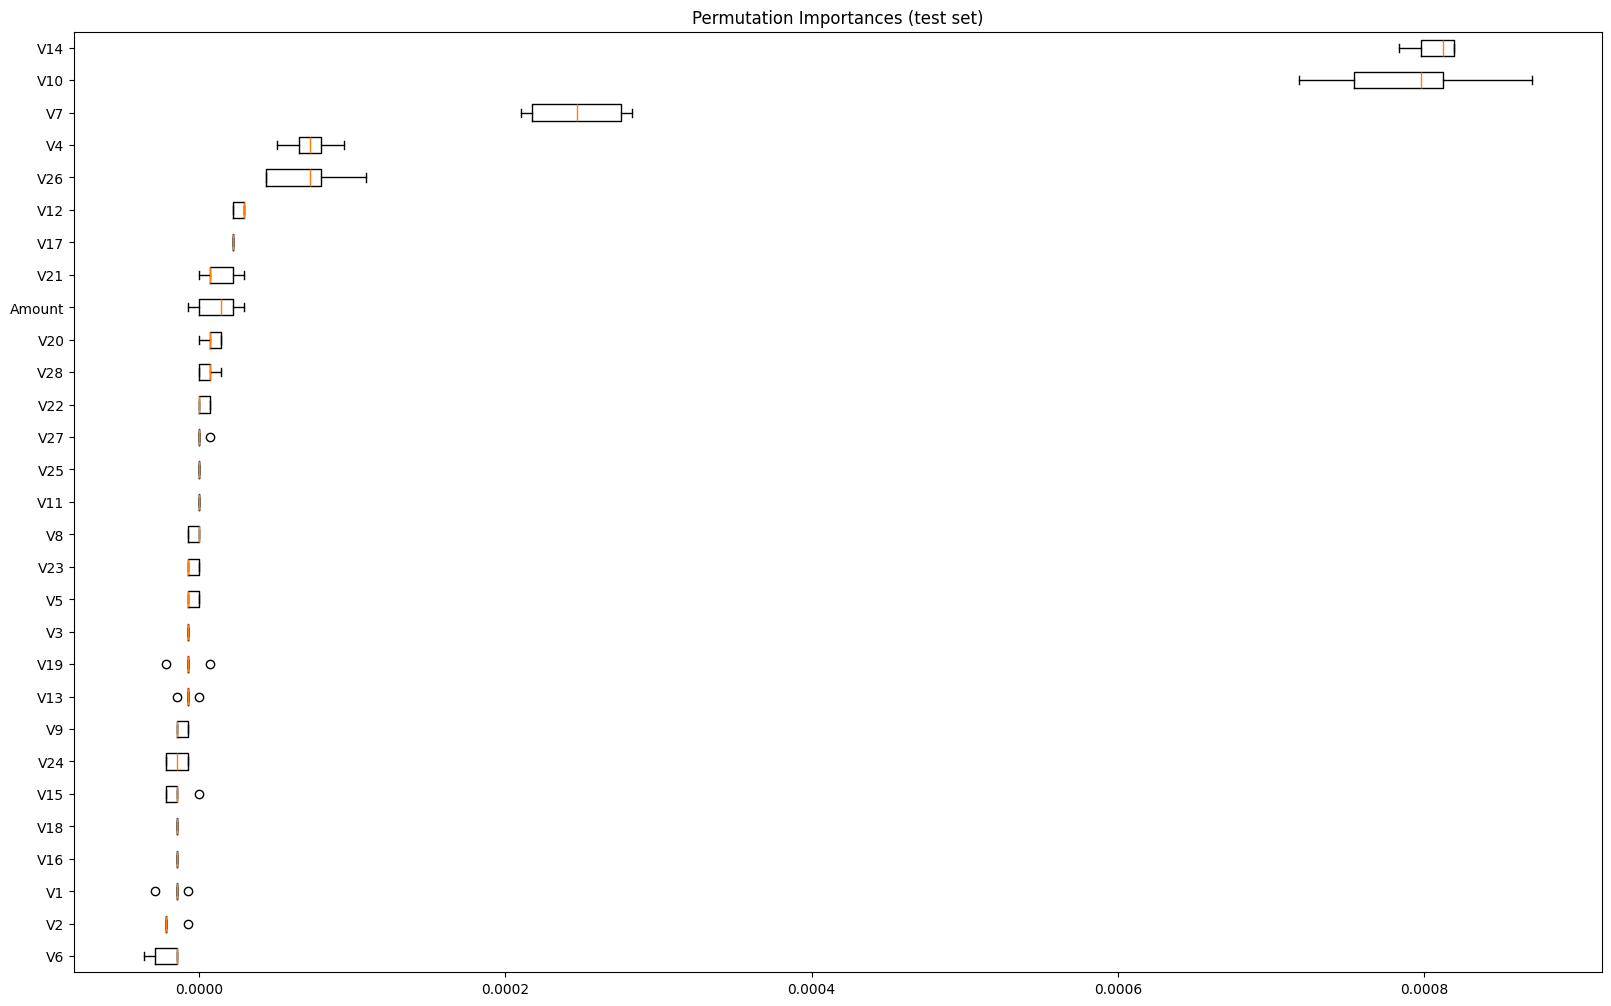

In [63]:
#df_clean = preprocess_data(df)
feature_names = df.drop('Class', axis=1).columns
feature_names
plot_feature_importance(best_xgb, X_test, y_test, feature_names)

In [1]:

import xgboost 
xgboost.__version__


'2.1.4'

In [3]:
!pip install -U xgboost

DEPRECATION: Loading egg at /home/adrian/Documents/ibm-certifications/venv/lib/python3.12/site-packages/pygame-2.6.1.dev1-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [1]:
import xgboost
xgboost.__version__

'2.1.4'